In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", -1)

import numpy as np

import pandas_profiling

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set_context("paper", font_scale=1.8)
sns.set_palette("GnBu_d")

import pickle

import math

from tqdm import tqdm_notebook as tqdm

# Dataset

The dataset consists of 6362620 rows and 11 columns. 

***step*** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

***type*** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

***amount*** - amount of the transaction in local currency (assume $).

***nameOrig*** - customer who started the transaction

***oldbalanceOrg*** - initial balance before the transaction

***newbalanceOrig*** - new balance after the transaction

***nameDest*** - customer who is the recipient of the transaction

***oldbalanceDest*** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

***newbalanceDest*** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

***isFraud*** - (TARGET) This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

***isFlaggedFraud*** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than $200,000 in a single transaction.

In [33]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv") 

In [34]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [35]:
df.rename(mapper={
    "nameOrig": "customer",
    "oldbalanceOrg": "customer_old_balance",
    "newbalanceOrig": "customer_new_balance",
    "nameDest": "recipient",
    "oldbalanceDest": "recipient_old_balance",
    "newbalanceDest": "recipient_new_balance",
    "isFraud": "is_fraud",
    "isFlaggedFraud": "is_flagged_fraud"
},
          axis=1,
          inplace=True)

df.head()

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


There are no null values:

In [7]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              6362620 non-null int64
type              6362620 non-null object
amount            6362620 non-null float64
nameOrig          6362620 non-null object
oldbalanceOrg     6362620 non-null float64
newbalanceOrig    6362620 non-null float64
nameDest          6362620 non-null object
oldbalanceDest    6362620 non-null float64
newbalanceDest    6362620 non-null float64
isFraud           6362620 non-null int64
isFlaggedFraud    6362620 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [36]:
# pickle.dump(df, open("df.pkl", "wb"))

In [105]:
df = pickle.load(open("df.pkl", "rb"))

In [0]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,6.36262e+06,NaN,NaN,NaN,243.397,142.332,1,156,239,335,743
type,6362620,5,CASH_OUT,2237500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,6.36262e+06,NaN,NaN,NaN,179862,603858,0,13389.6,74871.9,208721,9.24455e+07
customer,6362620,6353307,C1462946854,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
customer_old_balance,6.36262e+06,NaN,NaN,NaN,833883,2.88824e+06,0,0,14208,107315,5.9585e+07
customer_new_balance,6.36262e+06,NaN,NaN,NaN,855114,2.92405e+06,0,0,0,144258,4.9585e+07
recipient,6362620,2722362,C1286084959,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
recipient_old_balance,6.36262e+06,NaN,NaN,NaN,1.1007e+06,3.39918e+06,0,0,132706,943037,3.56016e+08
recipient_new_balance,6.36262e+06,NaN,NaN,NaN,1.225e+06,3.67413e+06,0,0,214661,1.11191e+06,3.56179e+08
is_fraud,6.36262e+06,NaN,NaN,NaN,0.00129082,0.0359048,0,0,0,0,1


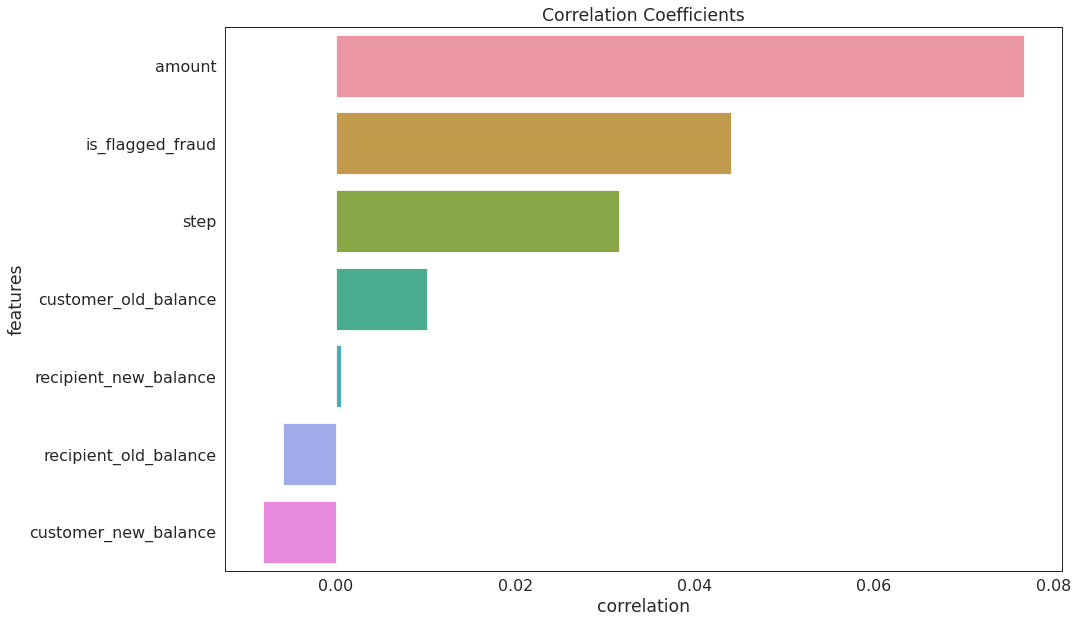

In [0]:
corr_table = df.corr()[["is_fraud"]].sort_values("is_fraud", ascending=False).iloc[1:,:].reset_index()
plt.figure(figsize=(15,10))
sns.barplot(x="is_fraud", y="index", data=corr_table)
plt.xlabel("correlation")
plt.ylabel("features")
plt.title("Correlation Coefficients")
plt.show()

# Exploratory Data Analysis

## Target: is_fraud

1: Transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

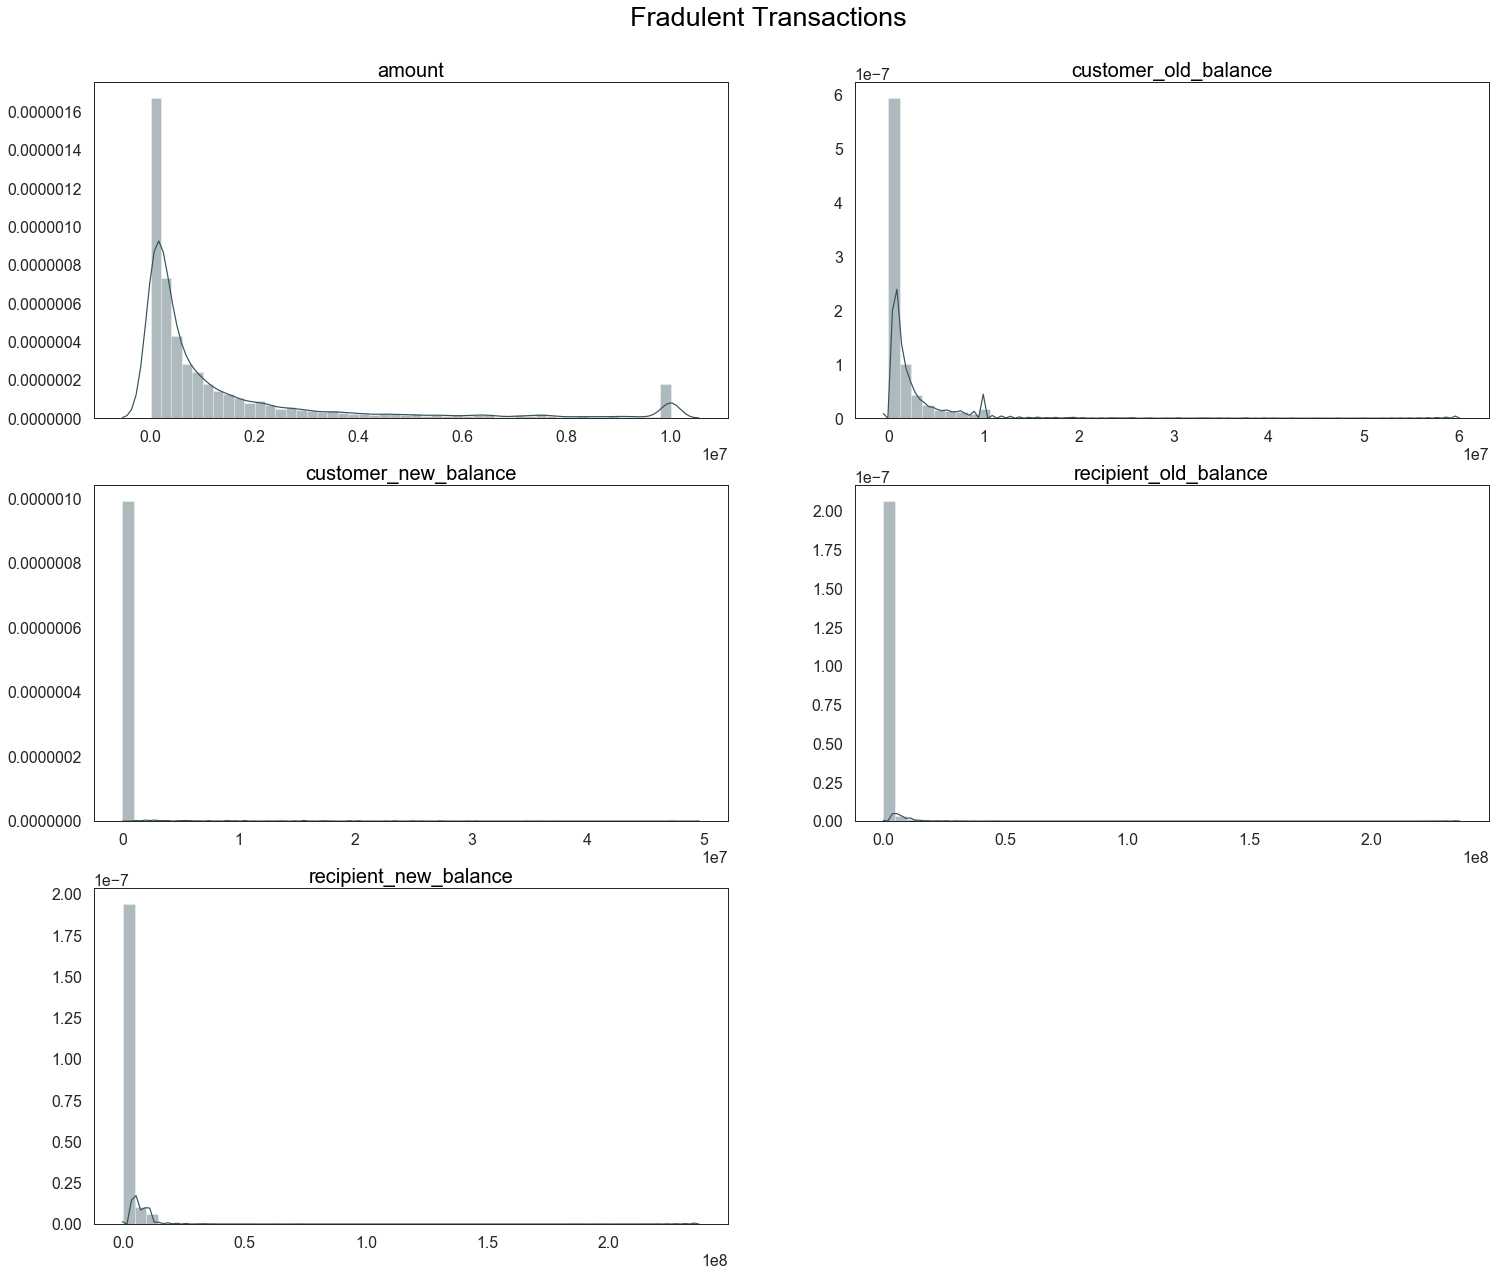

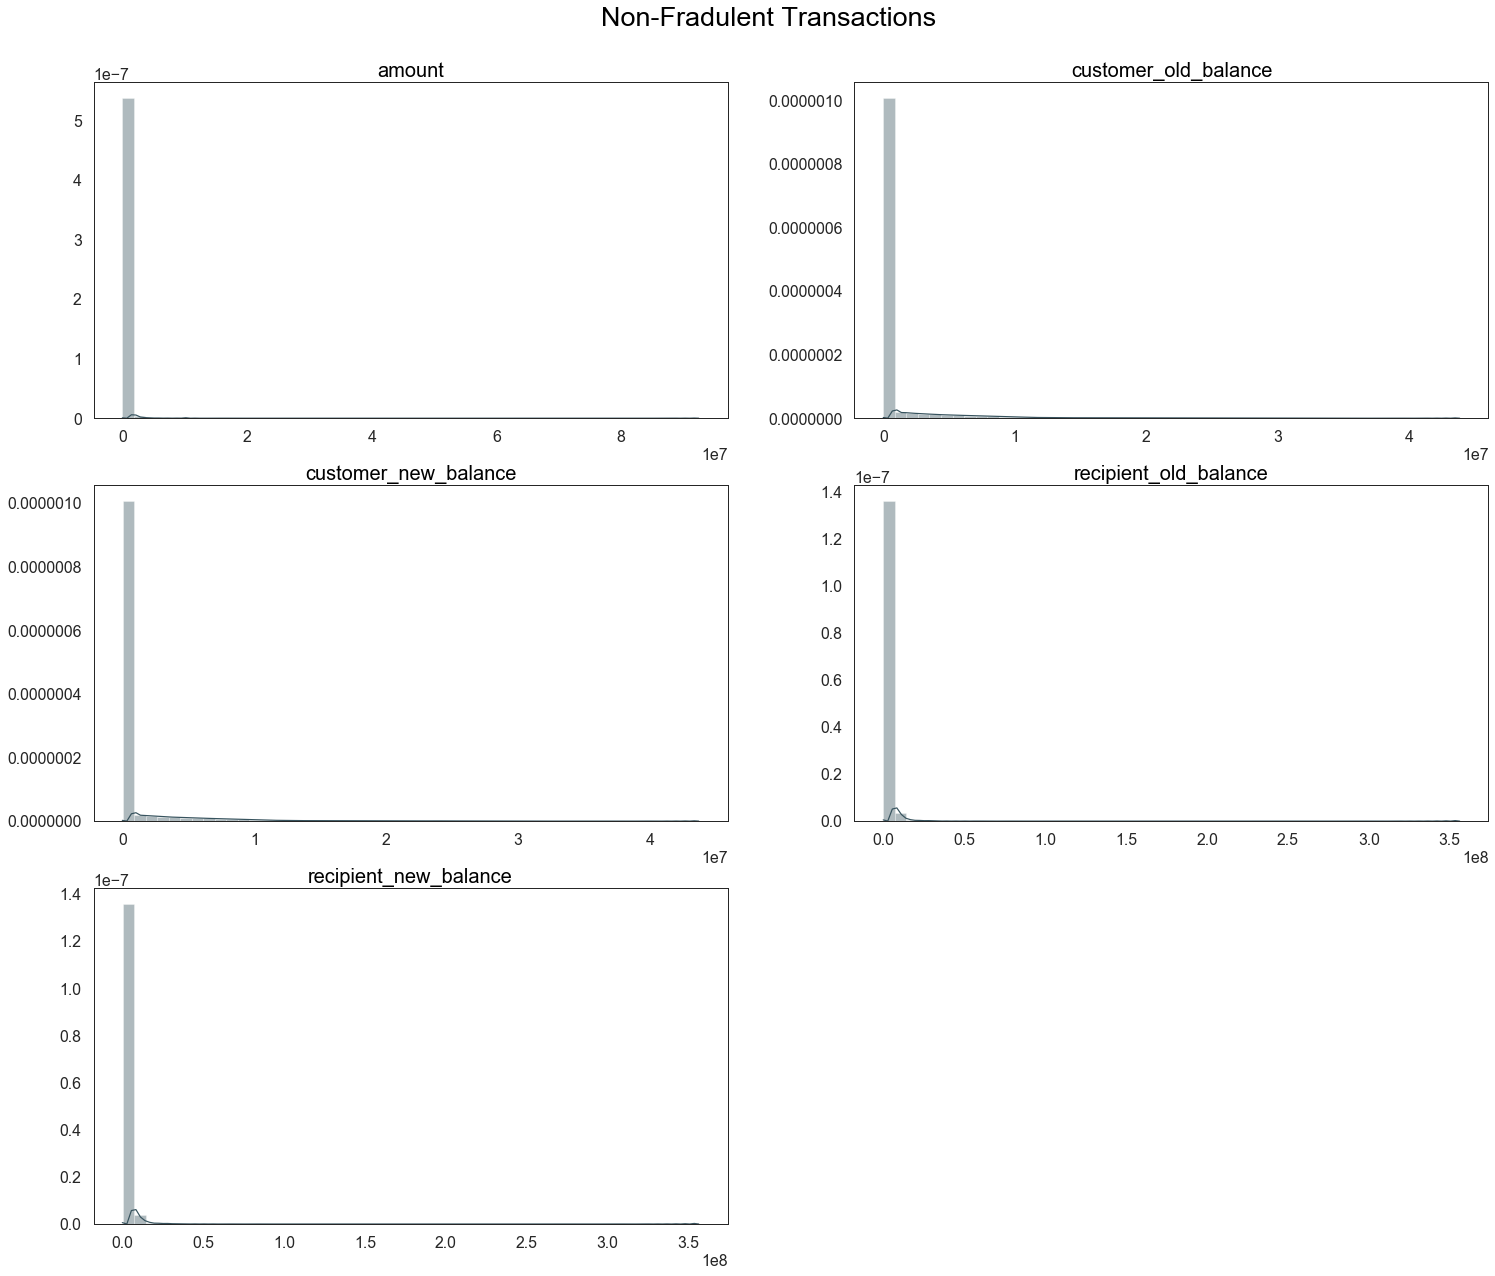

In [46]:
cols = [
    "amount", "customer_old_balance", "customer_new_balance",
    "recipient_old_balance", "recipient_new_balance"
]

r = math.ceil(len(cols)/2)

for key, val in dict(
        zip([1, 0],
            ["Fradulent Transactions", "Non-Fradulent Transactions"])).items():
    fig = plt.figure(figsize=(25, 7*r))
    for i, col in enumerate(cols):
        ax = fig.add_subplot(r, 2, i + 1)
        sns.distplot(df.query("is_fraud == @key")[col])
        plt.xlabel(None)
        plt.title(col, fontsize=20, color="black")
    plt.suptitle(val, fontsize=27, y=0.93, color="black")
    plt.show()

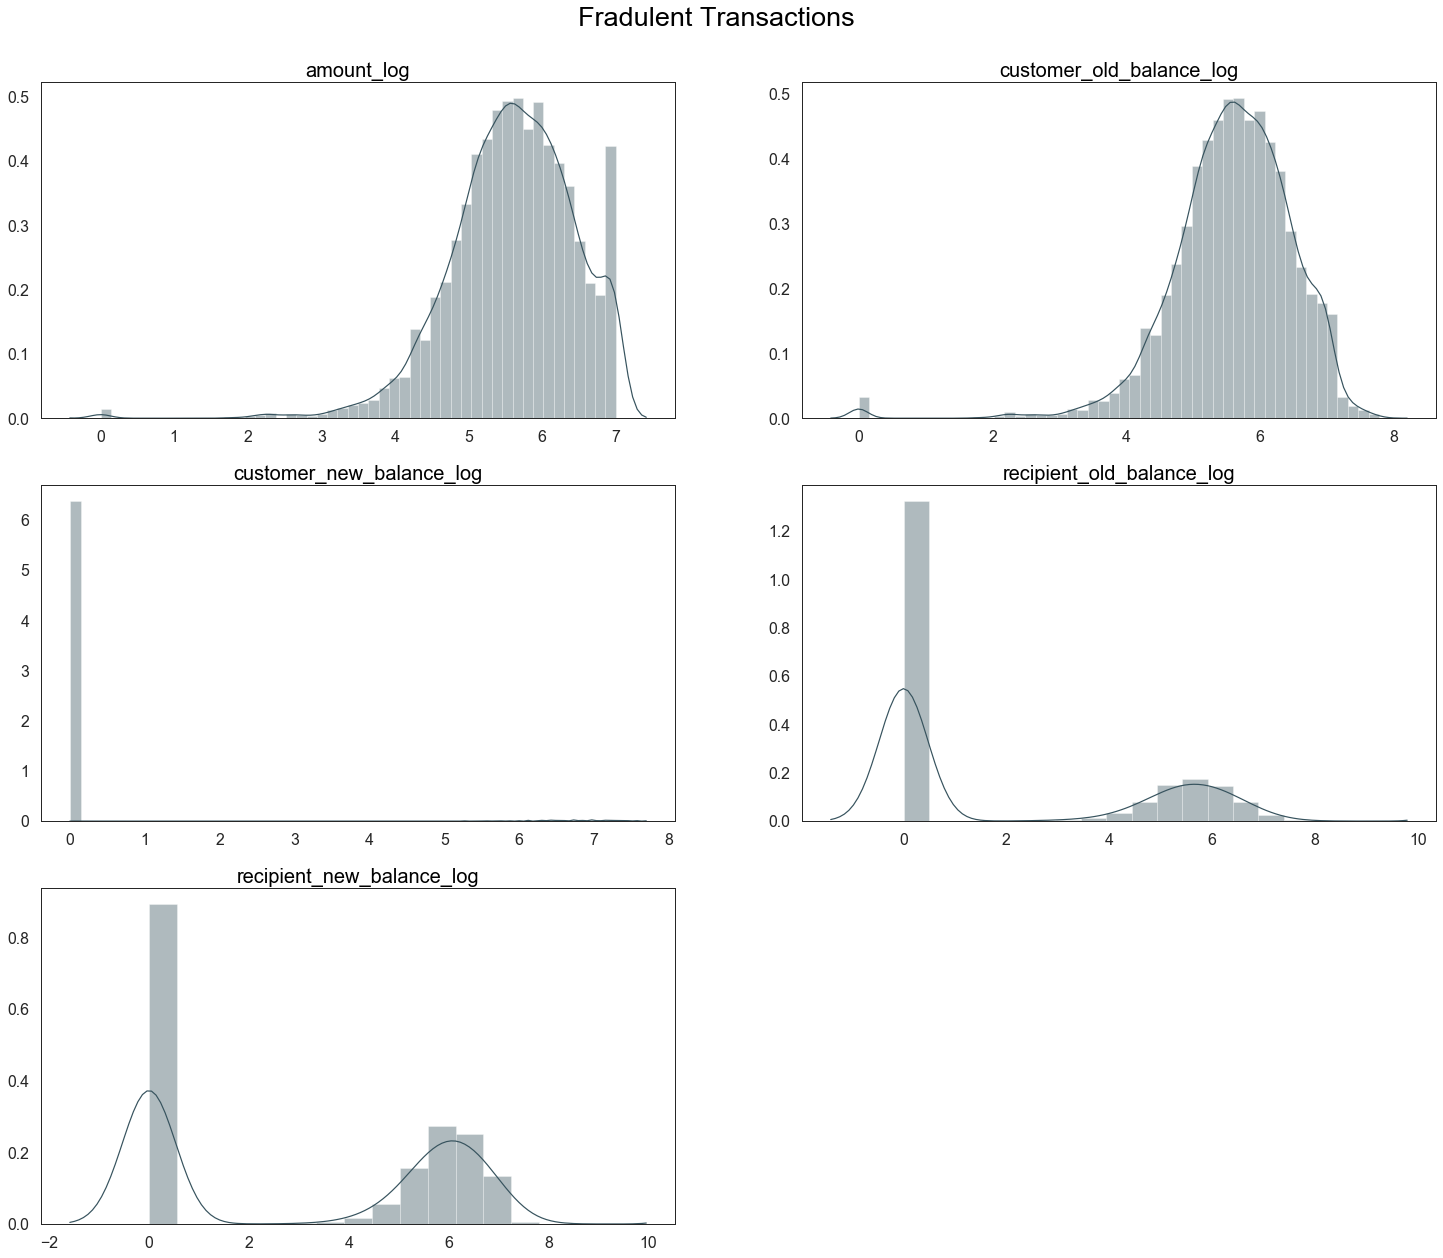

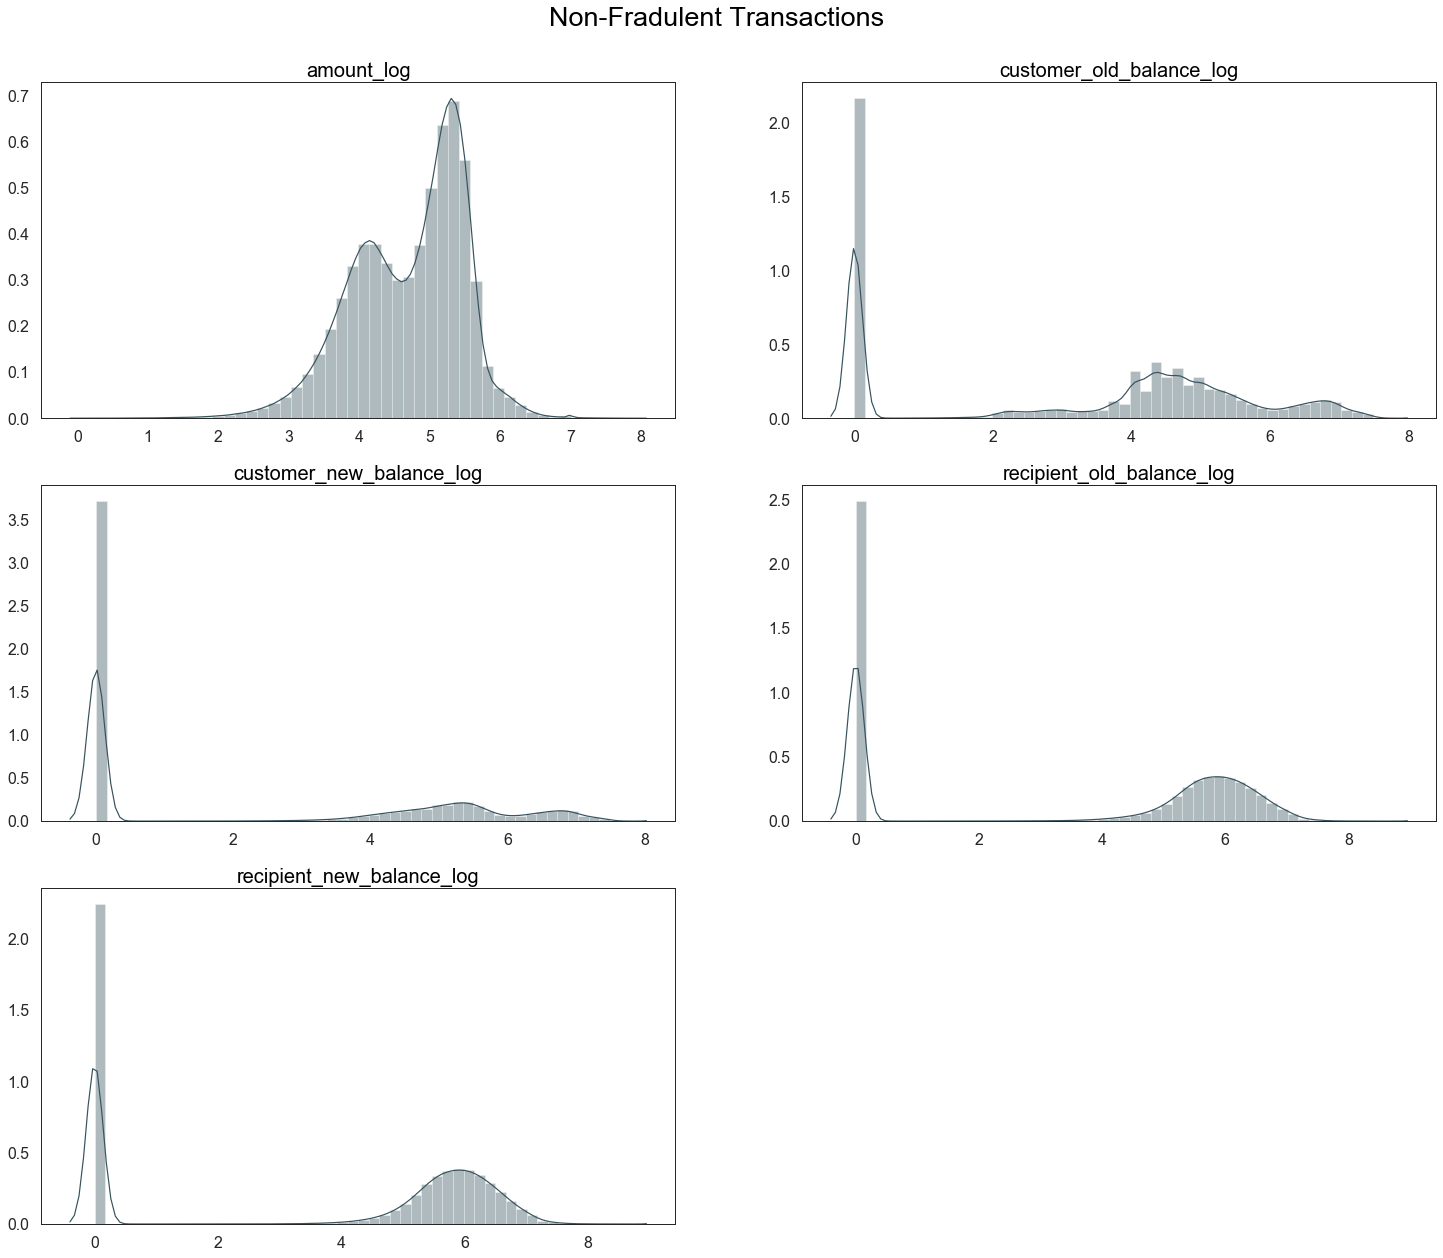

In [59]:
normalised = []
for col in cols:
    df[col+"_log"] = df[col].map(lambda x: np.log10(x+1))
    normalised.append(col+"_log")

r = math.ceil(len(cols)/2)

for key, val in dict(
        zip([1, 0],
            ["Fradulent Transactions", "Non-Fradulent Transactions"])).items():
    fig = plt.figure(figsize=(25, 7*r))
    for i, col in enumerate(normalised):
        ax = fig.add_subplot(r, 2, i + 1)
        sns.distplot(df.query("is_fraud == @key")[col])
        plt.xlabel(None)
        plt.title(col, fontsize=20, color="black")
    plt.suptitle(val, fontsize=27, y=0.93, color="black")
    plt.show()

## step

- Maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

Most of the transactions happened from 0 to 400. 

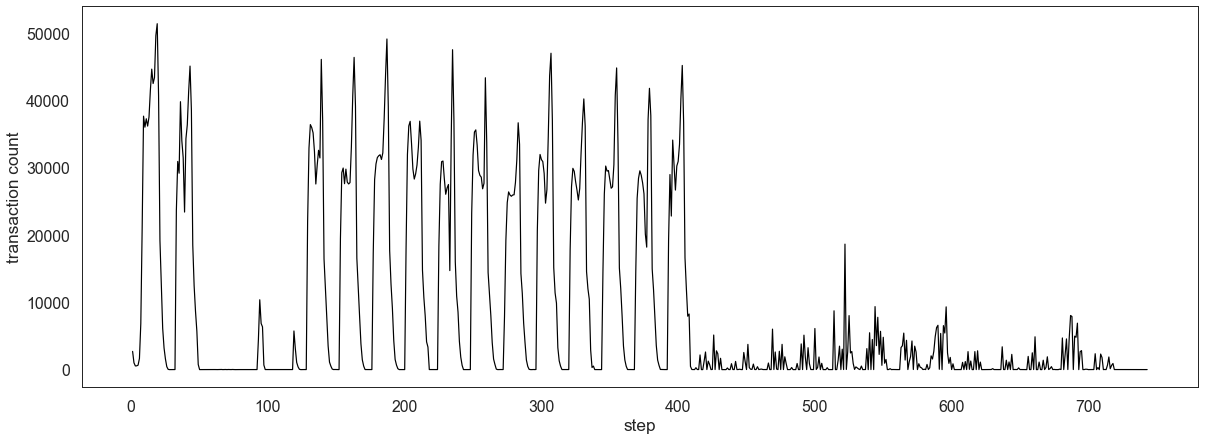

In [60]:
plt.figure(figsize=(20, 7))
sns.lineplot(x="step",
             y="amount",
             data=df.groupby(["step"]).count().reset_index(),
             color="black")
plt.xlabel("step")
plt.ylabel("transaction count")
plt.show()

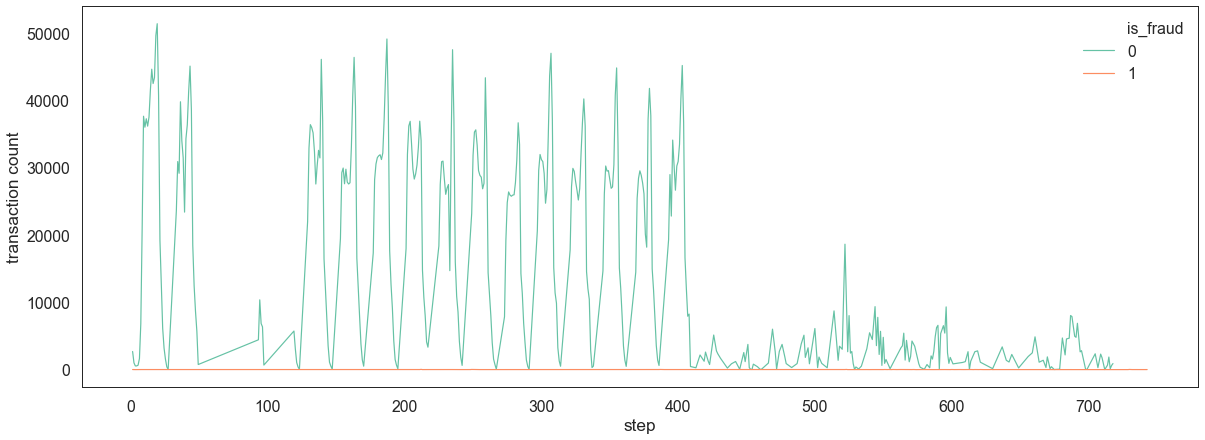

In [61]:
plt.figure(figsize=(20, 7))
sns.lineplot(x="step",
             y="amount",
             hue="is_fraud",
             data=df.groupby(["step", "is_fraud"]).count().reset_index(),
             palette="Set2")
plt.xlabel("step")
plt.ylabel("transaction count")
plt.show()

## type

- CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER

Most common types are CASH_OUT, PAYMENT and CASH_IN which comprises 91% of the dataset.  Fraudulent transactions are only found in CASH_OUT (50.12%) and TRANSFER (49.88%) transactions.

In [18]:
print("=====All Transactions=====")
print(df.type.value_counts(normalize=True)*100)

print("\n=====Fraudulent Transactions=====")
print(df.query("is_fraud == 1").type.value_counts(normalize=True)*100)

print("\n=====Non-Fraudulent Transactions=====")
print(df.query("is_fraud == 0").type.value_counts(normalize=True)*100)

=====All Transactions=====
CASH_OUT    35.166331
PAYMENT     33.814608
CASH_IN     21.992261
TRANSFER    8.375622 
DEBIT       0.651178 
Name: type, dtype: float64

=====Fraudulent Transactions=====
CASH_OUT    50.11567
TRANSFER    49.88433
Name: type, dtype: float64

=====Non-Fraudulent Transactions=====
CASH_OUT    35.147009
PAYMENT     33.858313
CASH_IN     22.020686
TRANSFER    8.321972 
DEBIT       0.652020 
Name: type, dtype: float64


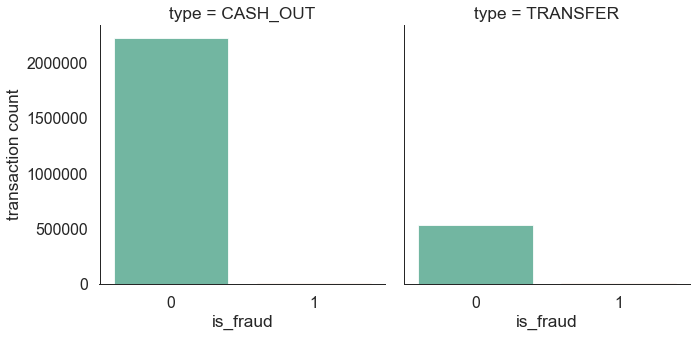

In [65]:
sns.catplot(x="is_fraud",
            y="transaction count",
            col="type",
            data=df[(df.type == "CASH_OUT") | (df.type == "TRANSFER")].groupby(
                ["type", "is_fraud"]).count().reset_index().rename(
                    mapper={"step": "transaction count"}, axis=1),
            kind="bar",
           palette="Set2")
plt.show()

In [64]:
for type_ in df.type.unique():
    if list(df.type.unique()).index(type_) == 0:
        print("====={}=====".format(type_))
    else:
        print("\n====={}=====".format(type_))
    print(df.query("type == @type_").is_fraud.value_counts(normalize=True)*100)

=====PAYMENT=====
0    100.0
Name: is_fraud, dtype: float64

=====TRANSFER=====
0    99.231201
1    0.768799 
Name: is_fraud, dtype: float64

=====CASH_OUT=====
0    99.816045
1    0.183955 
Name: is_fraud, dtype: float64

=====DEBIT=====
0    100.0
Name: is_fraud, dtype: float64

=====CASH_IN=====
0    100.0
Name: is_fraud, dtype: float64


## amount

The amount ranges from \\$0 to \\$92445516.64. The most common value is \\$10000000.00 which appeared 3207x. 287 transactions of which are fraudulent transactions, 3 of which were flagged as fraudulent.

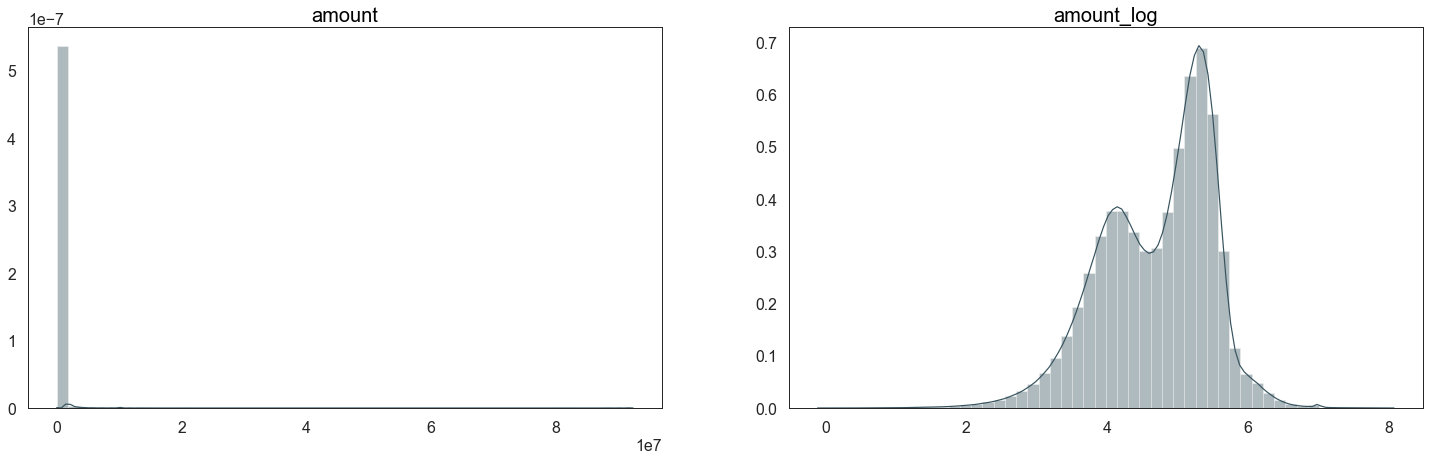

In [68]:
fig = plt.figure(figsize=(25, 7))
for i, col in enumerate(["amount", "amount_log"]):
    ax = fig.add_subplot(1, 2, i + 1)
    sns.distplot(df[col])
    plt.xlabel(None)
    plt.title(col, fontsize=20, color="black")
plt.show()

In [69]:
df.amount.value_counts().head()

10000000.0    3207
10000.0       88  
5000.0        79  
15000.0       68  
500.0         65  
Name: amount, dtype: int64

In [70]:
df[df.amount == 10000000].is_fraud.value_counts()

0    2920
1    287 
Name: is_fraud, dtype: int64

In [102]:
df[df.is_fraud == 1].amount.value_counts().head()

10000000.00    287
0.00           16 
429257.45      4  
1165187.89     4  
76646.05       2  
Name: amount, dtype: int64

In [103]:
df[df.is_flagged_fraud == 1].amount.value_counts().head()

10000000.00    3
3171085.59     1
2542664.27     1
4892193.09     1
3576297.10     1
Name: amount, dtype: int64

In [71]:
df[["amount", "is_fraud"]].pivot(columns="is_fraud").describe()

amount              
is_fraud             0             1
count     6.354407e+06  8.213000e+03
mean      1.781970e+05  1.467967e+06
std       5.962370e+05  2.404253e+06
min       1.000000e-02  0.000000e+00
25%       1.336840e+04  1.270913e+05
50%       7.468472e+04  4.414234e+05
75%       2.083648e+05  1.517771e+06
max       9.244552e+07  1.000000e+07

In [72]:
df[["amount", "is_flagged_fraud"]].pivot(columns="is_flagged_fraud").describe()

amount              
is_flagged_fraud             0             1
count             6.362604e+06  1.600000e+01
mean              1.798501e+05  4.861598e+06
std               6.037884e+05  3.572499e+06
min               0.000000e+00  3.538742e+05
25%               1.338955e+04  2.242749e+06
50%               7.487127e+04  4.234245e+06
75%               2.087205e+05  7.883451e+06
max               9.244552e+07  1.000000e+07

## customer, recipient

In [74]:
print("There are {} unique customer IDs.".format(df.customer.nunique()))

print("There are {} unique recipient IDs.".format(df.recipient.nunique()))

print("There are {} unique IDs in this dataset.".format(
    len(set(list(df.customer.unique()) + list(df.recipient.unique())))))

There are 6353307 unique customer IDs.
There are 2722362 unique recipient IDs.
There are 9073900 unique IDs in this dataset.


In [75]:
print("There are {} IDs that are both customer and recipient.".format(
    len(
        pd.DataFrame(df.customer.unique()).merge(pd.DataFrame(
            df.recipient.unique()),
                                                 how="inner"))))

There are 1769 IDs that are both customer and recipient.


In [77]:
print("There are {} IDs appeared more than once as customers.".format(
    len(df[df.customer.duplicated(keep="first") == True].customer)))

print("There are {} IDs appeared more than once as recipients.".format(
    len(df[df.recipient.duplicated(keep="first") == True].recipient)))

There are 9313 IDs appeared more than once as customers.
There are 3640258 IDs appeared more than once as recipients.


In [78]:
print("There are {} merchants that initiated transactions.".format(
    len(df[df.customer.str.contains("M")])))

print("There are {} merchants as recipients.".format(
    len(df[df.recipient.str.contains("M")])))

There are 0 merchants that initiated transactions.
There are 2151495 merchants as recipients.


In [79]:
cols = ["type", "is_fraud", "is_flagged_fraud"]
print("=====Merchant as Recipient=====")
for col in cols:
    print("FEATURE: ", col)
    print(df[df.recipient.str.contains("M")][col].value_counts(normalize=True)*100)

=====Merchant as Recipient=====
FEATURE:  type
PAYMENT    100.0
Name: type, dtype: float64
FEATURE:  is_fraud
0    100.0
Name: is_fraud, dtype: float64
FEATURE:  is_flagged_fraud
0    100.0
Name: is_flagged_fraud, dtype: float64


In [80]:
print(
    "There are {} customer IDs that initiated fraudulent transactions.".format(
        df[df.is_fraud == 1].customer.nunique()))

print("There are {} recipient IDs involved in fraudulent transactions.".format(
    df[df.is_fraud == 1].recipient.nunique()))

print("There are {} IDs involved in fraudulent transactions.".format(
    len(
        set(
            list(df[df.is_fraud == 1].customer.unique()) +
            list(df[df.is_fraud == 1].recipient.unique())))))

There are 8213 customer IDs that initiated fraudulent transactions.
There are 8169 recipient IDs involved in fraudulent transactions.
There are 16382 IDs involved in fraudulent transactions.


In [81]:
print(
    "There are {} customer IDs that initiated flagged transactions.".format(
        df[df.is_flagged_fraud == 1].customer.nunique()))

print("There are {} recipient IDs involved in flagged transactions.".format(
    df[df.is_flagged_fraud == 1].recipient.nunique()))

print("There are {} IDs involved in flagged transactions.".format(
    len(
        set(
            list(df[df.is_flagged_fraud == 1].customer.unique()) +
            list(df[df.is_flagged_fraud == 1].recipient.unique())))))

There are 16 customer IDs that initiated flagged transactions.
There are 16 recipient IDs involved in flagged transactions.
There are 32 IDs involved in flagged transactions.


In [6]:
# Get all IDs with fraud activity

IDs_with_fraud = list(set(list(df.query("is_fraud ==1").customer.unique()) + list(df.query("is_fraud ==1").recipient.unique())))

In [7]:
def check_history(idx, ID, s, c=1):
    df_ID = df[(df.customer==ID)| (df.recipient==ID)]
    for i in range(len(df_ID)):
        if (s > df_ID.step.iloc[i]) & (df_ID.is_fraud.iloc[i]==1):
            if c==1:
                df.at[idx,"customer_with_history"] = 1
            else:
                df.at[idx,"recipient_with_history"] = 1
            break
        else:
            continue

In [8]:
for i in tqdm(IDs_with_fraud):
    for idx, s in dict(
            zip(
                df[(df.customer == i) |
                   (df.recipient == i)].index,
                df[(df.customer == i) |
                   (df.recipient == i)].step.values)).items():
        check_history(idx, i, s, c=1)
        check_history(idx, i, s, c=0)

In [107]:
# pickle.dump(df, open("fraud_v1.pkl", "wb"))
df = pickle.load(open("fraud_v1.pkl", "rb"))
df.head()

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud,customer_with_history,recipient_with_history
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,NaN,NaN
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,NaN,NaN
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,NaN,NaN
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,NaN,NaN
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,NaN,NaN


In [108]:
df["with_history"] = df["customer_with_history"] + df["recipient_with_history"]
df.fillna(0, inplace=True)
df.isnull().sum()

step                      0
type                      0
amount                    0
customer                  0
customer_old_balance      0
customer_new_balance      0
recipient                 0
recipient_old_balance     0
recipient_new_balance     0
is_fraud                  0
is_flagged_fraud          0
customer_with_history     0
recipient_with_history    0
with_history              0
dtype: int64

In [117]:
print("There are {} transactions where customer IDs have had fraud history but was not flagged as fraud.".
      format(
          df.query(
              "customer_with_history == 1 & is_flagged_fraud == 0").shape[0]))

print("There are {} transactions where customer IDs have had fraud history but was not flagged as fraud.".
      format(
          df.query(
              "customer_with_history == 1 & is_flagged_fraud == 0").shape[0]))

There are 35626 transactions where customer IDs have had fraud history but was not flagged as fraud.


## customer_old_balance, customer_new_balance, recipient_old_balance, recipient_new_balance

In [106]:
df["customer_check_balance"] = df["customer_new_balance"] - (df["customer_old_balance"] - df["amount"])

df["recipient_check_balance"] = df["recipient_new_balance"] - (df["recipient_old_balance"] + df["amount"])

df.head()

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud,customer_check_balance,recipient_check_balance
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0,-9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.0,-1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.0,-181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.0,-21363.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.0,-11668.14


## is_flagged_fraud

/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


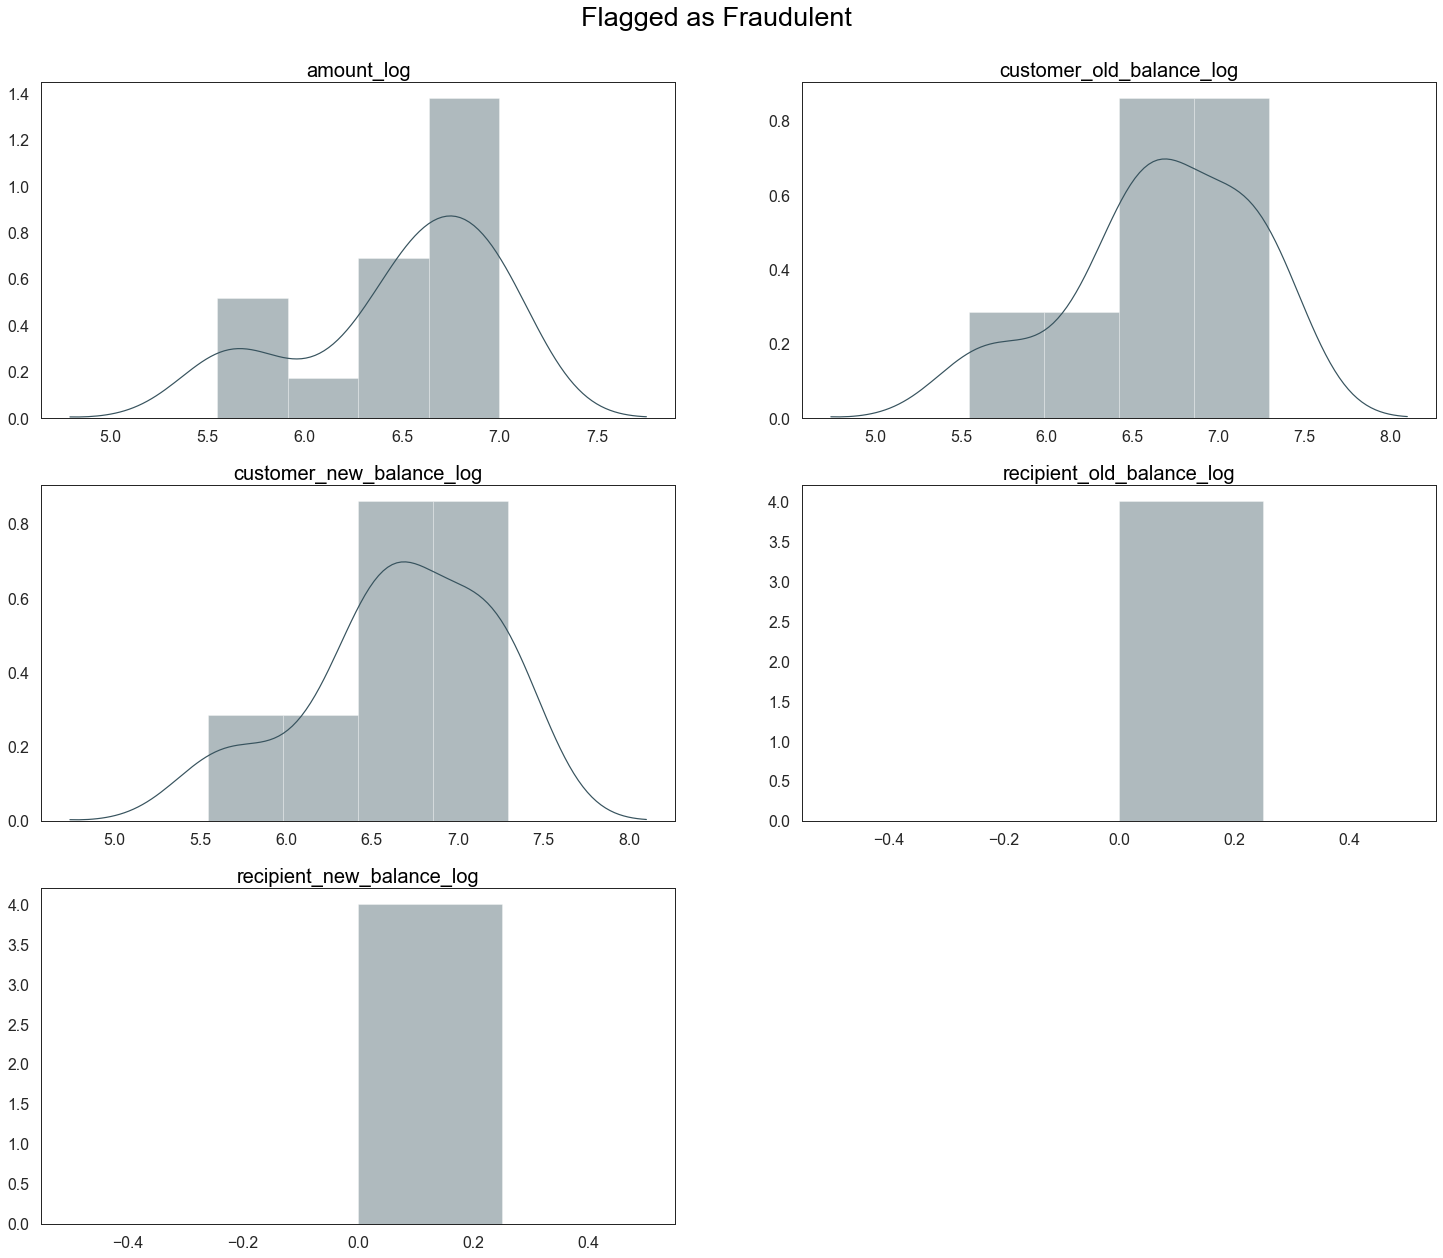

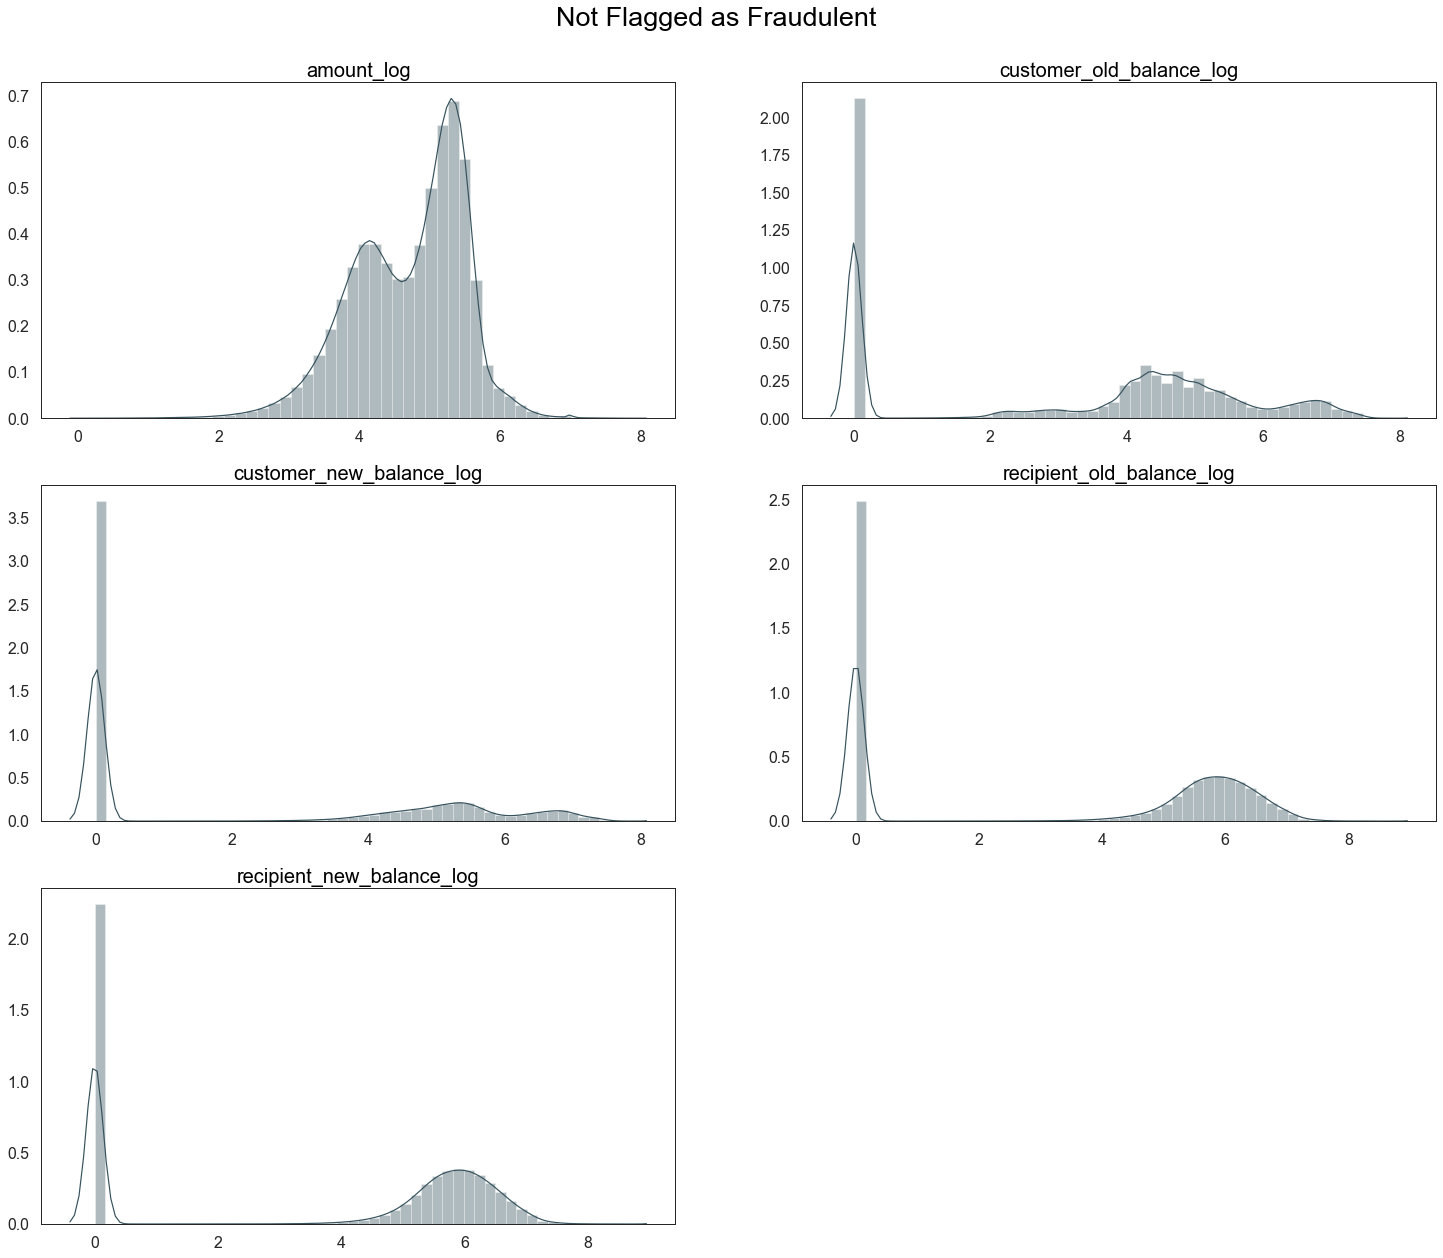

In [82]:
r = math.ceil(len(normalised)/2)

for key, val in dict(
        zip([1, 0],
            ["Flagged as Fraudulent", "Not Flagged as Fraudulent"])).items():
    fig = plt.figure(figsize=(25, 7*r))
    for i, col in enumerate(normalised):
        ax = fig.add_subplot(r, 2, i + 1)
        sns.distplot(df.query("is_flagged_fraud == @key")[col])
        plt.xlabel(None)
        plt.title(col, fontsize=20, color="black")
    plt.suptitle(val, fontsize=27, y=0.93, color="black")
    plt.show()

In [88]:
df = pickle.load(open("fraud_v1.pkl", "rb"))

In [89]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
step                      6362620 non-null int64
type                      6362620 non-null object
amount                    6362620 non-null float64
customer                  6362620 non-null object
customer_old_balance      6362620 non-null float64
customer_new_balance      6362620 non-null float64
recipient                 6362620 non-null object
recipient_old_balance     6362620 non-null float64
recipient_new_balance     6362620 non-null float64
is_fraud                  6362620 non-null int64
is_flagged_fraud          6362620 non-null int64
customer_with_history     35626 non-null float64
recipient_with_history    35626 non-null float64
dtypes: float64(7), int64(3), object(3)
memory usage: 631.1+ MB


In [100]:
df.fillna(0, inplace=True)
df.isnull().sum()

step                      0
type                      0
amount                    0
customer                  0
customer_old_balance      0
customer_new_balance      0
recipient                 0
recipient_old_balance     0
recipient_new_balance     0
is_fraud                  0
is_flagged_fraud          0
customer_with_history     0
recipient_with_history    0
dtype: int64

In [101]:
df["with_history"] = df["customer_with_history"] + df["recipient_with_history"]

In [ ]:
sns.

In [21]:
print("There are {} customers appeared more than once.".format(
    len(df[df.customer.duplicated(keep="first") == True].customer)))

There are 9313 customers appeared more than once.


In [22]:
print("There are {} recipients appeared more than once.".format(
    len(df[df.recipient.duplicated(keep="first") == True].recipient)))

There are 3640258 recipients appeared more than once.


In [23]:
print("There are {} IDs that are both customer and recipient.".format(
    len(
        pd.DataFrame(df.customer.unique()).merge(pd.DataFrame(
            df.recipient.unique()),
                                                 how="inner"))))

There are 1769 IDs that are both customer and recipient.


In [24]:
print("There are {} merchants that initiated transactions.".format(
    len(df[df.customer.str.contains("M")])))

There are 0 merchants that initiated transactions.


In [25]:
print("There are {} merchants as recipients.".format(
    len(df[df.recipient.str.contains("M")])))

There are 2151495 merchants as recipients.


In [26]:
cols = ["type", "is_fraud", "is_flagged_fraud"]
print("=====Merchant as Recipient=====")
for col in cols:
    print("FEATURE: ", col)
    print(df[df.recipient.str.contains("M")][col].value_counts(normalize=True)*100)

=====Merchant as Recipient=====
FEATURE:  type
PAYMENT    100.0
Name: type, dtype: float64
FEATURE:  is_fraud
0    100.0
Name: is_fraud, dtype: float64
FEATURE:  is_flagged_fraud
0    100.0
Name: is_flagged_fraud, dtype: float64


In [9]:
df["customer_check_balance"] = df["customer_new_balance"] - (df["customer_old_balance"] - df["amount"])

df["recipient_check_balance"] = df["recipient_new_balance"] - (df["recipient_old_balance"] + df["amount"])

In [12]:
pickle.dump(df, open("fraud.pkl", "wb"))

In [29]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
step                       6362620 non-null int64
type                       6362620 non-null object
amount                     6362620 non-null float64
customer                   6362620 non-null object
customer_old_balance       6362620 non-null float64
customer_new_balance       6362620 non-null float64
recipient                  6362620 non-null object
recipient_old_balance      6362620 non-null float64
recipient_new_balance      6362620 non-null float64
is_fraud                   6362620 non-null int64
is_flagged_fraud           6362620 non-null int64
customer_with_history      35626 non-null float64
recipient_with_history     35626 non-null float64
customer_check_balance     6362620 non-null float64
recipient_check_balance    6362620 non-null float64
dtypes: float64(9), int64(3), object(3)
memory usage: 728.1+ MB


In [30]:
df.fillna(0, inplace=True)
pickle.dump(df, open("fraud2.pkl", "wb"))

In [32]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 15 columns):
step                       6362620 non-null int64
type                       6362620 non-null object
amount                     6362620 non-null float64
customer                   6362620 non-null object
customer_old_balance       6362620 non-null float64
customer_new_balance       6362620 non-null float64
recipient                  6362620 non-null object
recipient_old_balance      6362620 non-null float64
recipient_new_balance      6362620 non-null float64
is_fraud                   6362620 non-null int64
is_flagged_fraud           6362620 non-null int64
customer_with_history      6362620 non-null float64
recipient_with_history     6362620 non-null float64
customer_check_balance     6362620 non-null float64
recipient_check_balance    6362620 non-null float64
dtypes: float64(9), int64(3), object(3)
memory usage: 728.1+ MB


In [14]:
del IDs_with_fraud

In [15]:
x = pickle.load(open("fraud.pkl", "rb"))
display(x.head())
del x

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud,customer_with_history,recipient_with_history,customer_check_balance,recipient_check_balance
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,NaN,NaN,0.0,-9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,NaN,NaN,0.0,-1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,NaN,NaN,0.0,-181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,NaN,NaN,0.0,-21363.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,NaN,NaN,0.0,-11668.14


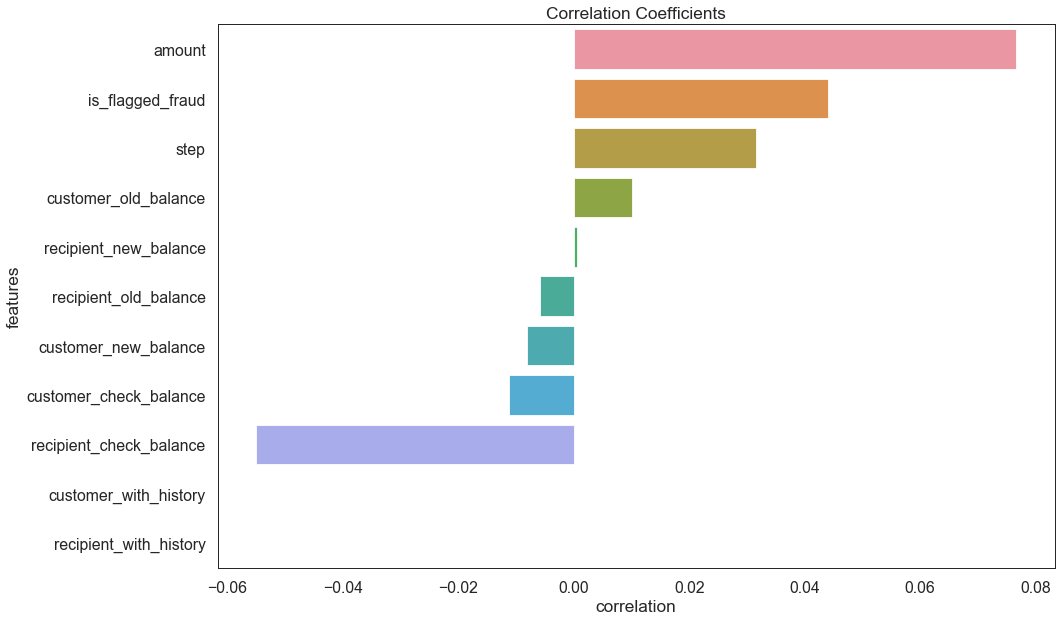

In [10]:
corr_table = df.corr()[["is_fraud"]].sort_values("is_fraud", ascending=False).iloc[1:,:].reset_index()
plt.figure(figsize=(15,10))
sns.barplot(x="is_fraud", y="index", data=corr_table)
plt.xlabel("correlation")
plt.ylabel("features")
plt.title("Correlation Coefficients")
plt.show()

In [82]:
df_fraud = df.query("is_fraud == 1")
df_not_fraud = df.query("is_fraud == 0")
df_flagged = df.query("is_flagged_fraud == 1")
df_not_flagged = df.query("is_flagged_fraud == 0")

In [83]:
print("There are {} customers with fraudulent transactions".format(
    df_fraud.customer.nunique()))

There are 8213 customers with fraudulent transactions


In [84]:
print("There are {} recipient under fraudulent transactions".format(
    df_fraud.recipient.nunique()))

There are 8169 recipient under fraudulent transactions


In [85]:
print(
    "There are {} customers who have made both fraudulent and non-fraudulent transactions."
    .format(
        len(df_fraud[["customer"]].merge(df_not_fraud[["customer"]],
                                         how="inner"))))

There are 28 customers who have made both fraudulent and non-fraudulent transactions.


In [87]:
print(
    "There are {} IDs who have been recipient of both fraudulent and non-fraudulent transactions."
    .format(
        len(df_fraud[["recipient"]].merge(df_not_fraud[["recipient"]],
                                         how="inner"))))

There are 58186 IDs who have been recipient of both fraudulent and non-fraudulent transactions.


In [88]:
print(
    "There are {} customers who have both flagged and not flagged transactions ."
    .format(
        len(df_flagged[["customer"]].merge(df_not_flagged[["customer"]],
                                           how="inner"))))

There are 0 customers who have both flagged and not flagged transactions .


In [90]:
print(
    "There are {} recipients who have both flagged and not flagged transactions ."
    .format(
        len(df_flagged[["recipient"]].merge(df_not_flagged[["recipient"]],
                                           how="inner"))))

There are 8 recipients who have both flagged and not flagged transactions .


In [91]:
print(
    "There are {} IDs who have fraudulent transactions as both customer and recipient."
    .format(
        len(df_fraud[["customer"]].merge(df_fraud[["recipient"]],
                                         how="inner",
                                         left_on="customer",
                                         right_on="recipient"))))

There are 0 IDs who have fraudulent transactions as both customer and recipient.


In [92]:
print(
    "There are {} IDs who have fraudulent transactions as customer but none as recipient."
    .format(
        len(df_fraud[["customer"]].merge(df_not_fraud[["recipient"]],
                                         how="inner",
                                         left_on="customer",
                                         right_on="recipient"))))

There are 0 IDs who have fraudulent transactions as customer but none as recipient.


In [93]:
df.query("is_flagged_fraud==0 & (customer_with_history==1 | recipient_with_history==1) & is_fraud==1")

,step,type,amount,customer,customer_old_balance,customer_new_balance,recipient,recipient_old_balance,recipient_new_balance,is_fraud,is_flagged_fraud,customer_with_prior,recipient_with_prior
4858,5,CASH_OUT,120074.73,C1174000532,120074.73,0.0,C410033330,0.00,120074.73,1,0,0,1
1030736,88,CASH_OUT,4022408.76,C987446721,4022408.76,0.0,C1981613973,4542879.50,8565288.26,1,0,0,1
1048324,95,CASH_OUT,87999.25,C409531429,87999.25,0.0,C1827219533,0.00,87999.25,1,0,0,1
1059579,105,CASH_OUT,511379.90,C1440012977,511379.90,0.0,C644163395,3439249.70,3950629.60,1,0,0,1
3208638,249,CASH_OUT,369448.20,C2020495090,369448.20,0.0,C650699445,0.00,369448.20,1,0,0,1
6008662,436,CASH_OUT,4135944.29,C1649836304,4135944.29,0.0,C14138104,0.00,4135944.29,1,0,0,1
6168708,560,CASH_OUT,143275.81,C1571623448,143275.81,0.0,C1655359478,6346481.09,6489756.90,1,0,0,1
6255874,597,CASH_OUT,517183.38,C1850286862,517183.38,0.0,C1837027614,0.00,517183.38,1,0,0,1
6272188,621,CASH_OUT,425861.93,C2103073329,425861.93,0.0,C686334805,203280.85,629142.78,1,0,0,1
6281786,650,CASH_OUT,50523.78,C1711085884,50523.78,0.0,C1148781766,0.00,50523.78,1,0,0,1
